### Setting Up

In [126]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
from pprint import pprint
from scipy.stats import randint, uniform

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score, cross_validate,learning_curve, train_test_split, KFold, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import export_graphviz


# To plot pretty figures
%matplotlib inline
from graphviz import Source
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
    
# to make this notebook's output stable across runs
np.random.seed(42)

### Utility Functions

In [127]:
def plot_class_regions_for_classifier_subplot(clf, X, y, X_test, y_test, title, subplot, target_names = None, plot_decision_regions = True):

    numClasses = np.amax(y) + 1
    color_list_light = ['#FFFFAA', '#EFEFEF', '#AAFFAA', '#AAAAFF']
    color_list_bold = ['#EEEE00', '#000000', '#00CC00', '#0000CC']
    cmap_light = ListedColormap(color_list_light[0:numClasses])
    cmap_bold  = ListedColormap(color_list_bold[0:numClasses])

    h = 0.03
    k = 0.5
    x_plot_adjust = 0.1
    y_plot_adjust = 0.1
    plot_symbol_size = 50

    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()
    x2, y2 = np.meshgrid(np.arange(x_min-k, x_max+k, h), np.arange(y_min-k, y_max+k, h))

    P = clf.predict(np.c_[x2.ravel(), y2.ravel()])
    P = P.reshape(x2.shape)

    if plot_decision_regions:
        subplot.contourf(x2, y2, P, cmap=cmap_light, alpha = 0.8)

    subplot.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=plot_symbol_size, edgecolor = 'black')
    subplot.set_xlim(x_min - x_plot_adjust, x_max + x_plot_adjust)
    subplot.set_ylim(y_min - y_plot_adjust, y_max + y_plot_adjust)

    if (X_test is not None):
        subplot.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, s=plot_symbol_size, marker='^', edgecolor = 'black')
        train_score = clf.score(X, y)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    subplot.set_title(title)

    if (target_names is not None):
        legend_handles = []
        for i in range(0, len(target_names)):
            patch = mpatches.Patch(color=color_list_bold[i], label=target_names[i])
            legend_handles.append(patch)
        subplot.legend(loc=0, handles=legend_handles)


def plot_class_regions_for_classifier(clf, X, y, X_test=None, y_test=None, title=None, target_names = None, plot_decision_regions = True):

    numClasses = np.amax(y) + 1
    color_list_light = ['#FFFFAA', '#EFEFEF', '#AAFFAA', '#AAAAFF']
    color_list_bold = ['#EEEE00', '#000000', '#00CC00', '#0000CC']
    cmap_light = ListedColormap(color_list_light[0:numClasses])
    cmap_bold  = ListedColormap(color_list_bold[0:numClasses])

    h = 0.03
    k = 0.5
    x_plot_adjust = 0.1
    y_plot_adjust = 0.1
    plot_symbol_size = 50

    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()
    x2, y2 = np.meshgrid(np.arange(x_min-k, x_max+k, h), np.arange(y_min-k, y_max+k, h))

    P = clf.predict(np.c_[x2.ravel(), y2.ravel()])
    P = P.reshape(x2.shape)
    plt.figure()
    if plot_decision_regions:
        plt.contourf(x2, y2, P, cmap=cmap_light, alpha = 0.8)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=plot_symbol_size, edgecolor = 'black')
    plt.xlim(x_min - x_plot_adjust, x_max + x_plot_adjust)
    plt.ylim(y_min - y_plot_adjust, y_max + y_plot_adjust)

    if (X_test is not None):
        plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, s=plot_symbol_size, marker='^', edgecolor = 'black')
        train_score = clf.score(X, y)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    if (target_names is not None):
        legend_handles = []
        for i in range(0, len(target_names)):
            patch = mpatches.Patch(color=color_list_bold[i], label=target_names[i])
            legend_handles.append(patch)
        plt.legend(loc=0, handles=legend_handles)

    if (title is not None):
        plt.title(title)
    plt.show()
    

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
def plot_feature_importances(clf, feature_names):
    c_features = len(feature_names)
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(np.arange(c_features), feature_names)
    
def getScores(estimator, x, y):
    yPred = estimator.predict(x)
    return (accuracy_score(y, yPred), 
        precision_score(y, yPred, pos_label=3, average='macro'), 
        recall_score(y, yPred, pos_label=3, average='macro'))

def my_scorer(estimator, x, y):
    a, p, r = getScores(estimator, x, y)
    print (a, p, r)
    return a+p+r


#### Loading in the Data

In [148]:
#Loading in the Data
df = pd.read_csv("./water_potability.csv")

In [149]:
#Filling in the missing values

#Filling NaN pH Values
df["ph"].fillna(value = df["ph"].mean(), inplace = True)

#Filling NaN Sulfate Values
df["Sulfate"].fillna(value = df["Sulfate"].mean(), inplace = True)

#Filling NaN Trihalomethanes Values
df["Trihalomethanes"].fillna(value = df["Trihalomethanes"].mean(), inplace = True)

Creating the testing data

In [150]:
X = df.iloc[: , :-1]
y = df['Potability']
feature_names = X.columns;

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

# a) Neural Net

In [136]:
from sklearn.neural_network import MLPClassifier
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_water_2d = df[['Solids','Turbidity']]
y_water_2d = df['Potability']

X_water_scaled = scaler.fit_transform(X_water_2d)

nnX_train, nnX_test, nny_train, nny_test = train_test_split(X_water_scaled, y_water_2d.to_numpy(), random_state=0)

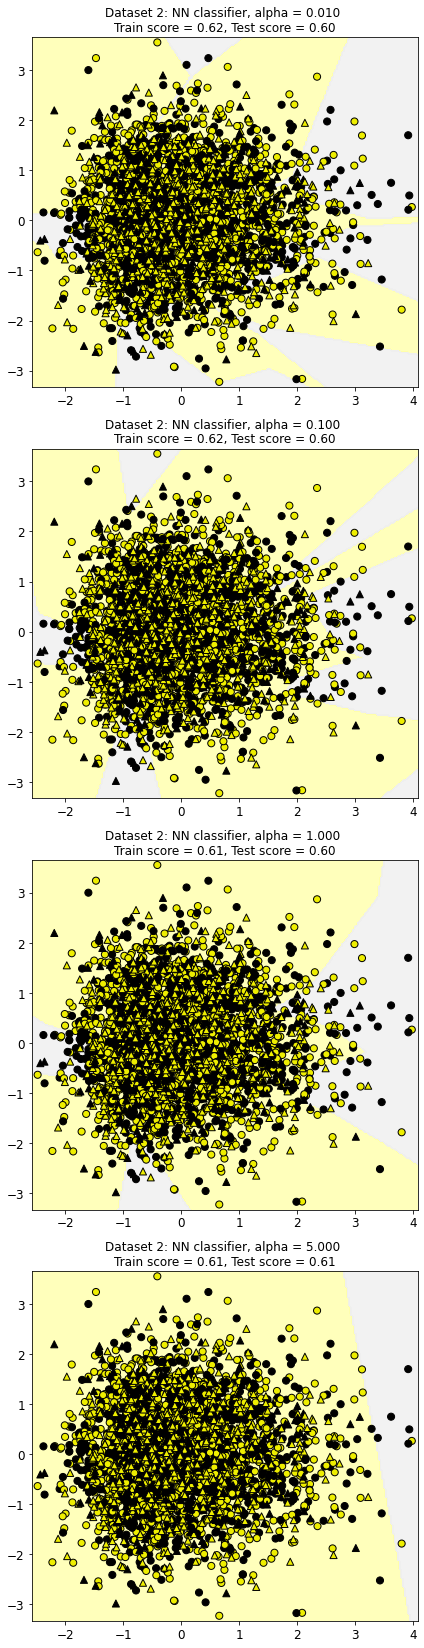

In [116]:
fig, subaxes = plt.subplots(4, 1, figsize=(6, 23))

for this_alpha, axis in zip([0.01, 0.1, 1.0, 5.0], subaxes):
    nnclf = MLPClassifier(solver='lbfgs', activation = 'relu',
                         alpha = this_alpha,
                         hidden_layer_sizes = [10, 10],
                         random_state = 0,
                         max_iter=10000).fit(nnX_train, nny_train)
    
    title = 'Dataset 2: NN classifier, alpha = {:.3f} '.format(this_alpha)
    
    plot_class_regions_for_classifier_subplot(nnclf, nnX_train, nny_train,
                                             nnX_test, nny_test, title, axis)
    plt.tight_layout()

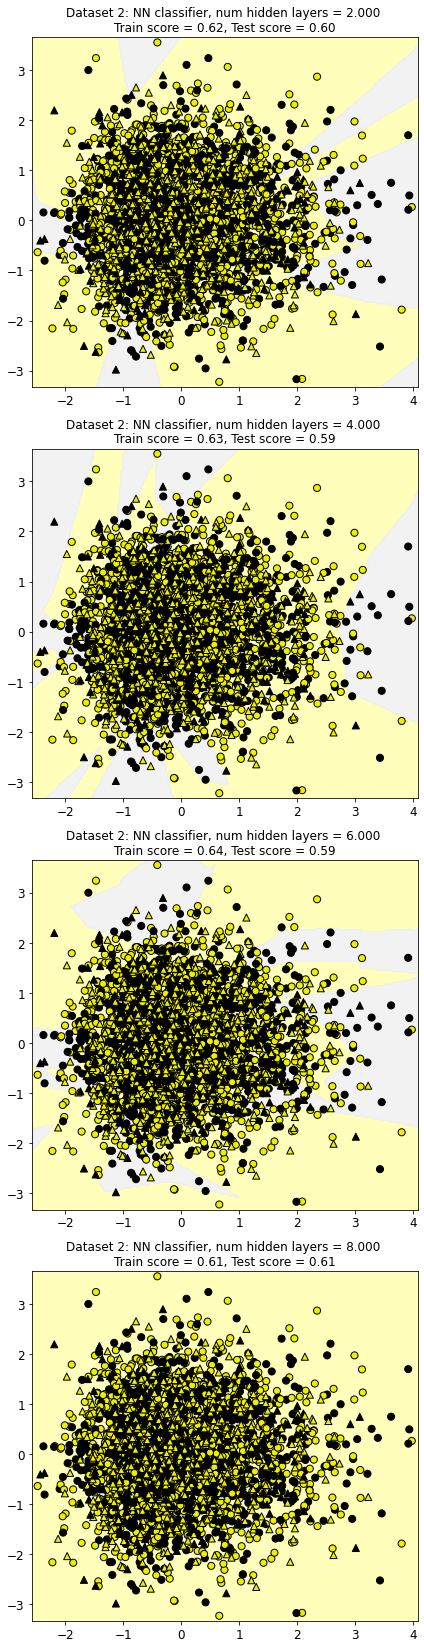

In [119]:
fig, subaxes = plt.subplots(4, 1, figsize=(6, 23))

hidden_layers = []

for axis in subaxes:
    hidden_layers.append(10)
    hidden_layers.append(10)
    nnclf = MLPClassifier(solver='lbfgs', activation = 'relu',
                         alpha = 0.1,
                         hidden_layer_sizes = hidden_layers,
                         random_state = 0,
                         max_iter=10000).fit(nnX_train, nny_train)
    
    title = 'Dataset 2: NN classifier, num hidden layers = {:.3f} '.format(len(hidden_layers))
    
    plot_class_regions_for_classifier_subplot(nnclf, nnX_train, nny_train,
                                             nnX_test, nny_test, title, axis)
    plt.tight_layout()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


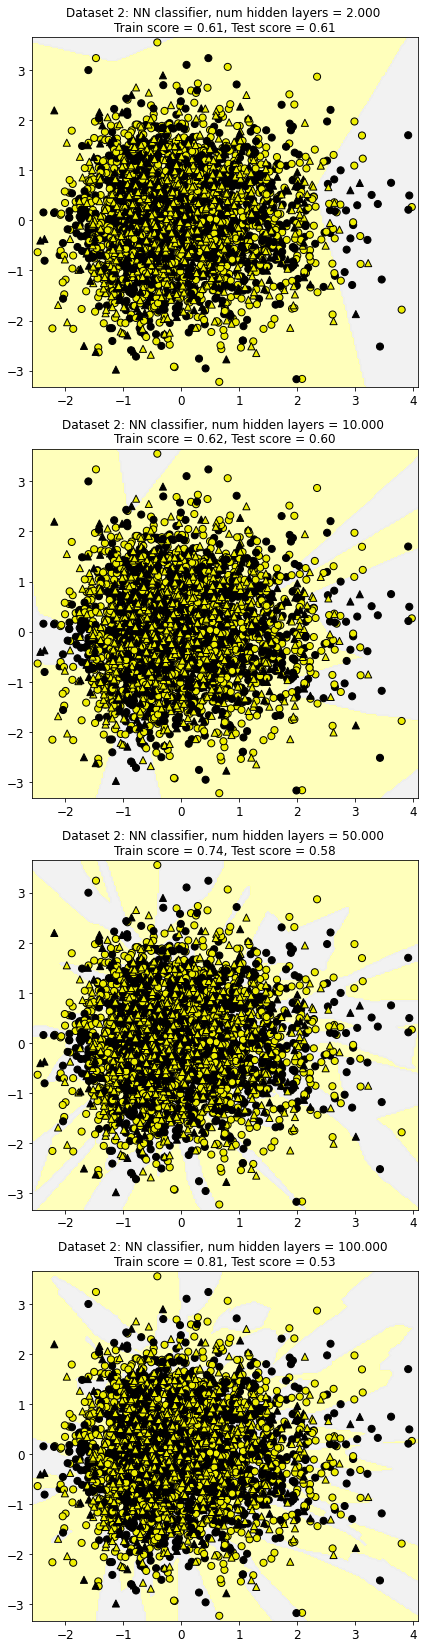

In [121]:
fig, subaxes = plt.subplots(4, 1, figsize=(6, 23))

num_nodes = [2, 10, 50, 100]

for nodes, axis in zip(num_nodes, subaxes):
    nnclf = MLPClassifier(solver='lbfgs', activation = 'relu',
                         alpha = 0.1,
                         hidden_layer_sizes = [nodes, nodes],
                         random_state = 0,
                         max_iter=100000).fit(nnX_train, nny_train)
    
    title = 'Dataset 2: NN classifier, num nodes per layer = {:.3f} '.format(nodes)
    
    plot_class_regions_for_classifier_subplot(nnclf, nnX_train, nny_train,
                                             nnX_test, nny_test, title, axis)
    plt.tight_layout()

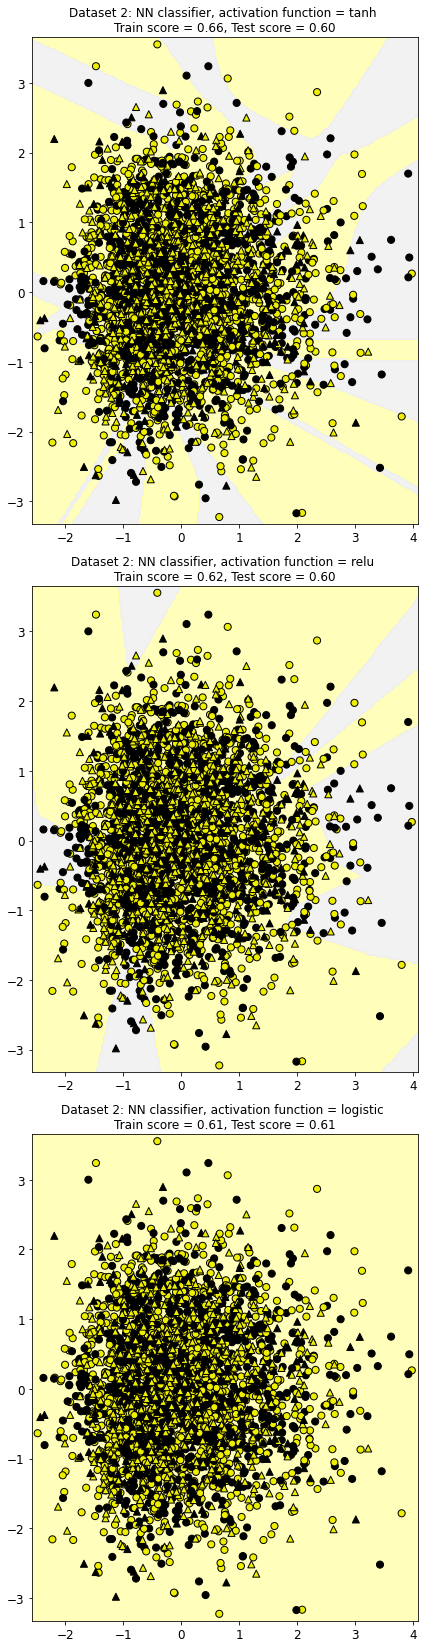

In [125]:
fig, subaxes = plt.subplots(3, 1, figsize=(6, 23))

activations = ['tanh', 'relu', 'logistic']

for activation, axis in zip(activations, subaxes):
    nnclf = MLPClassifier(solver='lbfgs', activation = activation,
                         alpha = 0.1,
                         hidden_layer_sizes = [10,10],
                         random_state = 0,
                         max_iter=10000).fit(nnX_train, nny_train)
    
    title = 'Dataset 2: NN classifier, activation function = {0} '.format(activation)
    
    plot_class_regions_for_classifier_subplot(nnclf, nnX_train, nny_train,
                                             nnX_test, nny_test, title, axis)
    plt.tight_layout()

# b) Comparative Analysis

In [ ]:
# create a Naive Bayes classifier using the training data
nbclf = GaussianNB()
nbclf.fit(X_train, y_train)

In [ ]:
# KNN CV search
model_params = {
    "n_neighbors": [1, 10],
    "weights": ["uniform", "distance"],
    "algorithm": ["ball_tree", "kd_tree", "brute"],
    "p":[1, 2] 
}

knn = KNeighborsClassifier()
clf = RandomizedSearchCV(knn, model_params, n_iter=24, cv=5, random_state=1)

knn_model = clf.fit(X_train, y_train)

pprint(knn_model.best_estimator_.get_params())

In [ ]:
model_params = {
    "max_depth": [1, 10],
    "max_features": randint(1,9),
    'min_samples_split': uniform(0.01, 0.199),
    "min_samples_leaf": randint(1,9),
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
}

dec_tree = DecisionTreeClassifier()
clf = RandomizedSearchCV(dec_tree, model_params, n_iter=100, cv=5, random_state=1)

dt_model = clf.fit(X_train, y_train)

pprint(dt_model.best_estimator_.get_params())

In [130]:
nnclf = MLPClassifier(solver='lbfgs', activation = 'tanh',
                         alpha = 0.1,
                         hidden_layer_sizes = [10,10,10,10,10,10],
                         random_state = 0,
                         max_iter=10000).fit(nnX_train, nny_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [143]:
models = []
results = []
names = []
accuracies = []
recalls = []
precisions = []
f1_scores = []
roc_scores = []
# scoring = 'accuracy'
scoring = {'acc': 'accuracy',
            'prec_macro': 'precision_macro',
            'rec_micro': 'recall_macro',
            'f1_score': 'f1',
            'roc': 'roc_auc'}

models.append(('NB', nbclf))
models.append(('KNN', knn_model))
models.append(('DT', dt_model))   

for name, model in models:
    kfold = KFold(n_splits=10, random_state=None)
    cv_results = cross_validate(model, X_test, y_test, cv=kfold, scoring=scoring)
    y_pred = model.predict(X_test)
    #y_pred = knn_model.predict(X_test)
    # confusion_mat = confusion_matrix(y_test, y_pred)
    # confusion_matrixes.append((name, confusion_mat))
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results["test_acc"].mean(), cv_results["test_acc"].std())
    print(msg)
    
    
for model in results:
    accuracies.append(model["test_acc"])
    recalls.append(model["test_rec_micro"])
    precisions.append(model["test_prec_macro"])
    f1_scores.append(model["test_f1_score"])
    roc_scores.append(model["test_roc"])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


NB: 0.547004 (0.052168)
KNN: 0.557964 (0.047777)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DT: 0.586043 (0.039881)


In [140]:
for model in results:
    accuracies.append(model["test_acc"])
    recalls.append(model["test_rec_micro"])
    precisions.append(model["test_prec_macro"])
    f1_scores.append(model["test_f1_score"])
    roc_scores.append(model["test_roc"])

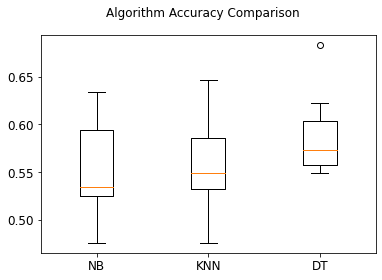

None

In [144]:
fig = plt.figure()
fig.suptitle('Algorithm Accuracy Comparison')
ax = fig.add_subplot(111)
plt.boxplot(accuracies)
ax.set_xticklabels(names)
display(plt.show())

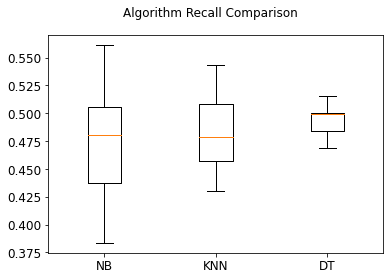

In [145]:
fig = plt.figure()
fig.suptitle('Algorithm Recall Comparison')
ax = fig.add_subplot(111)
plt.boxplot(recalls)
ax.set_xticklabels(names)
plt.show()

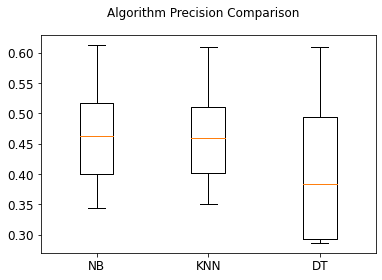

In [146]:
fig = plt.figure()
fig.suptitle('Algorithm Precision Comparison')
ax = fig.add_subplot(111)
plt.boxplot(precisions)
ax.set_xticklabels(names)
plt.show()

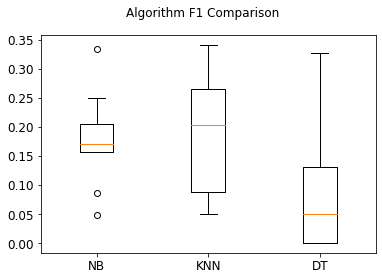

In [147]:
fig = plt.figure()
fig.suptitle('Algorithm F1 Comparison')
ax = fig.add_subplot(111)
plt.boxplot(f1_scores)
ax.set_xticklabels(names)
plt.show()